Ch5. 컴퓨터 비전을 위한 딥러닝
----------

### 5.1 Introduction to convnets

convnets(컨브넷) 이라고 불리는 convolution neural network(합성곱 신경망)에 대한 학습

우선 예제를 살펴보자.

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras import models, layers

%matplotlib inline

Using TensorFlow backend.


In [2]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


**convnets**이 (image_height, image_width, image_channels) 크기의 입력 텐서를 사용한다는 점이 중요
- 예제에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하도록 컨브넷을 설정해야 함
- 그래서 첫 layer의 parameter input_shape=(28, 28, 1)를 설정함

Conv2D와 MaxPooling2D층의 출력은 (height, width, channels) 크기의 3D 텐서이다.
- 높이와 넓이 차원은 네트워크가 깊어질수록 작아지는 경향이 있다.
- 채널의 수는 Conv2D 층에 전달된 첫 번째 매개변수에 의해 조절됨(32개 또는 64개)

다음 단계에서 마지막 층의 ((3, 3, 64) 크기) 추력 텐서를 fully connected network에 넣는다.
- 분류기는 1D 벡터를 처리하는데 이전 출력이 3D 텐서
- 그래서 3D 출력을 1D 텐서로 펼쳐야함
- 그 다음 몇 개의 Dense 층을 추가함

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

(3, 3, 64) -> (576,) 벡터로 펼쳐진 후 Dense로 넘어감

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [7]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 19s 312us/step - loss: 0.1801 - accuracy: 0.9443
Epoch 2/5
60000/60000 [==============================] - 20s 327us/step - loss: 0.0466 - accuracy: 0.9855
Epoch 3/5
60000/60000 [==============================] - 20s 340us/step - loss: 0.0320 - accuracy: 0.9902
Epoch 4/5
60000/60000 [==============================] - 18s 301us/step - loss: 0.0245 - accuracy: 0.9923
Epoch 5/5
60000/60000 [==============================] - 19s 311us/step - loss: 0.0198 - accuracy: 0.9938


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 116us/step


0.9919000267982483

**왜 컨브넷이 더 좋은 퍼포먼스를....?**

#### 5.1.1 합성곱 연산

근본적인 차이
- Dense layer는 입력 특성 공간에 있는 전역 패턴(예를 들면 MNIST 숫자 이미지에서는 모든 픽셀에 걸친 패턴)을 학습하지만 합성곱 층은 지역 패턴을 학습
- 이미지일 경우 작은 2D window로 입력에서 패턴을 찾음
- 앞의 예에서는 3x3 크기였음

핵심적인 특정인 두 가지 성질을 알려줌
- **학습된 패턴은 평행 이동 불변성(translation invariant)를 가짐**
  - 컨브넷이 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳에서도 이 패턴을 인식 할 수 있다.
  - 완전 연결 네트워크는 새로운 위치에 나타난 것은 새로운 패턴으로 학습해야함(상대적으로 안 좋은 이유임)
  - 이런 성질 때문에 컨브넷이 이미지를 효율적으로 처리하게 만들어 줌(근본적으로 우리가 보는 세상은 평행 이동으로 인해 다르게 인식 되지 않음..결국 사람이네)
  - 적은 수의 훈련 샘플을 사용해서 일반화 능력을 가진 표현을 학습할 수 있다.


- **컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있다**
  - 첫 번째 합성곱층이 에지 같은 작은 지역 패턴을 학습함
  - 두 번째 합성곱층이 첫 번째 층의 특성으로 구성된 더 큰 패턴을 학습하는 식
  - 이런 방식을 사용하여 컨브넷은 매우 복잡하고 추상적인 시각적 개념을 효과적으로 학습할 수 있다.
    - 근본적으로 우리가 보는 세상은 공간적 계층 구조를 가짐
    

![alt text](https://www.researchgate.net/profile/Hassan_Hassan45/publication/337830197/figure/fig3/AS:834037371379712@1575861413309/Schematic-diagram-of-the-proposed-edge-detectors-using-simple-CNN-setting.jpg)

합성곱 연산은 feature map(특성 맵)이라고 부르는 3D 텐서에 적용
- 이 텐서는 2개의 공간 축(높이와 넓이)과 깊이 축(채널 축)으로 구성 됨
- RGB이미지는 3개의 컬러 채널(빨, 녹, 파)을 가지므로 깊이 축의 차원이 3이 됨
- MNIST 숫자처럼 흑백 이미지는 깊이 축의 차원이 1(회색 톤)이다.
- 합성곱 연산은 입력 특성 맵에서 작은 patch를 추출하고 이런 모든 패치에 같은 변환을 적용하여 output feature map(출력 특성 맵)을 만듬

**output feature map**도 높이와 넓이를 가진 3D 텐서
- 출력 텐서의 깊이는 층의 매개변수로 결정되므로 상황에 따라 다름
- 이렇게 되면 깊이 축의 채널은 더 이상 RGB 입력처럼 특정 컬러를 의미하지 않음
- 그 대신 일종의 filter(필터)를 의미
- MNIST 예제에서는 첫 번째 합성곱 층이 (28, 28, 1) 크기의 특성 맵을 입력으로 받아 (26, 26, 32)크기의 특성 맵을 출력, 이 값은 입력데 대한 필터의 response map(응답 맵) 이다. 입력의 각 위체엇 필터 패턴에 대한 응답을 나타냄
  - 즉 입력에 대해 32개의 필터를 적용
  - 필터 하나의 크기는 (patch_height, patch_width, input_depth)
  - 첫 번째 합성곱은 (3, 3, 1) 크기의 필터를 32개 적용하고, 두 번쨰 합성곱은 (3, 3, 32) 크기의 필터를 64개 적용
- 특성 맵이란 말이 의미하는 것은....
  - 깊이 축에 있는 각 차원은 하나의 특성(또는 필터)이고, 2D 텐서 output[:, :, n]은 입력에 대한 이 필터 응답을 나타내는 2D 공간상의 맵
  

![alt text](https://i.ytimg.com/vi/HMcx-zY8JSg/maxresdefault.jpg)

합성곱은 핵심적인 2개의 parameter로 정의
- 입력으로부터 뽑아낼 패치의 크기 : 전형적으로 3X3 또는 5X5 크기를 사용, 이 예에서는 일반적으로 많이 사용하는 3X3 크기를 사용
- 특성 맵의 출력 깊이 : 합성곱으로 계산할 필터의 수, 이 예에서는 깊이 32로 시작해서 깊이 64로 끝남


- 3D 입력 특성 맵 위를 3 X 3 또는 5 X 5 window가 슬라이딩 하면서 모든 위치에서 3D 특성 패치((window_height, window_width, input_depth))를 추출하는 방식으로 합성곱이 작동
- 위의 결과는 1D 벡터로 변환
- 변환된 모든 벡터는 (height, width, output_depth) 크기의 3D 특성 맵으로 재구성
  - 출력 높이, 넓이는 입력 높이, 넓이와 다를 수 있다.
    - 경계 문제, 입력 특성 맵의 패딩을 추가하여 대응 할 수 있기 때문이다.
    - stride 의 사용 여부에 따라 다르다.
    
    
좋은 참고 자료
- https://je-d.tistory.com/entry/%ED%95%A9%EC%84%B1%EA%B3%B1-%EC%8B%A0%EA%B2%BD%EB%A7%9DCNN
- http://taewan.kim/post/cnn/

**경계 문제와 패딩 이해하기**

- 입력과 동일한 높이와 넓이를 가진 feature map을 얻고 싶다면 padding 을 사용할 수 있음
  - paramter는 2개의 값이 가능
  - valid 는 패딩을 사용하지 않는다는 뜻
  - same 은 입력과 동일한 높이와 넓이를 가진 출력을 만들기 위해 패딩한다 라는 뜻
  - 기본 매개변수는 valid 이다.

![alt text](https://miro.medium.com/max/666/1*noYcUAa_P8nRilg3Lt_nuA.png)

**합성곱 스트라이드 이해하기**

출력 크기에 영향을 미치는 다른 요소는 스트라이드
- 위에서의 설명들은 윈도우가 중앙 타일이 연속적으로 지나간다고 가정한 것
- 두 번의 연속적인 윈도우 사이의 거리가 스트라이드라고 불리는 합성곱의 파라미터이다.
- 기본 값은 1
- 1보다 큰 스트라이드 합성곱도 가능

#### 5.1.2 max pooling

max pooling은 입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최댓값을 출력하는 합성곱과 개념적으로 비슷하지만 추출한 패치에 학습된 선형 변환을 적용하는 대신에 하드코딩된 최댓값 추출 연산을 사용

max pooling은 feature map의 크기를 다운샘플링한다는 것


왜하냐?
- 처리할 특성 맵의 가중치 개수를 줄이기 위해서이다.
- 연산이 부담되니까
- 연속적인 합성곱 층이 점점 커진 윈도우를 통해 바라보도록 만들어 필터의 공간적인 계층 구조를 구성

물론 max pooling이 다운샘플링 할 수 있는 유일한 방법은 아니다. 스트라이드도 응용하면 할 수 있다.
- max pooling 대신에 average pooling도 가능하다.
- 하지만 max pooling이 더 잘 작동함
  - 특성이 특성 맵의 각 타일에서 어떤 패턴이나 개념의 존재 여부를 인코딩하는 경향이 있기 때문(그래서 feature map이라고 함)
  - 따라서 평균값보다 여러 특성 중 최댓값을 사용하는 것이 더 유용

### 5.2 소규모 데이터셋에서 밑바닥부터 CNN 훈련하기

전체적인 프로세스는 아래와 같다.
- 처음부터 작은 모델을 훈련하기
- 사전 훈련된 네트워크로 특성을 추출
- 사전 훈련된 네트워크를 세밀하게 튜닝

#### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성
데이터가 많아야 딥러닝이 잘 작동한다는 부분적으로 맞는 말
- 딥러닝의 특징은 feature engineering 없이도 특성을 찾을 수 있는 점
- 그래서 많아야 가능

하지만 많은 샘플이 의미하는 것은 상대적
- 우선 훈련하려는 네트워크의 크기와 깊이에 상대적
- 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능
- 하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분히 할 수 있다.
- 컨브넷은 지역적이고 평행 이동으로 변하지 않는 특성을 학습하기 때문에 지각에 관한 문제에서 매우 효율적으로 데이터셋 사용

#### 5.2.2 데이터 내려받기

In [10]:
import os, shutil

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'train'

# The directory where we will
# store our smaller dataset
base_dir = 'cats_and_dogs_small'
os.mkdir(base_dir)

In [11]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [12]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [13]:
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [14]:
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [15]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [16]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [17]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))


total validation cat images: 500


In [18]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [19]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [20]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


#### 5.2.3 네트워크 구성하기(building our network)

MNIST 할 때 사용한 구조에다가 Conv2D(relu) + MaxPooling2D 를 하나 더 넣어서 빌딩 할 예정
- 150 X 150 크기의 입력(임의로 선택한 크기)으로 시작해서 flatten 층 이전에 7 x 7 크기의 특성 맵으로 줄어듬

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 Dense 층)과 sigmoid 활성화 함수로 끝난다.
- 이 유닛은 한 클래스에 대한 확률을 인코딩 할 것이다.

In [21]:
from keras import layers
from keras import models

In [25]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [27]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### 5.2.4 데이터 전처리

데이터는 네트워크에 들어가기 전에 부동 소수 타입의 텐서로 적절하게 전처리 되어야함

1. 사진 파일을 읽는다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩한다.
3. 그다음 부동 소수 타입의 텐서로 변환한다.
4. 픽셀 값(0에서 255사이)의 스케일을 [0, 1] 사이로 조정한다.(신경망은 작은 입력 값을 선호한다.)


It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

> `keras.preprocessing.image` : 이미지 처리를 위한 헬퍼 도구들, `ImageDataGenerator` : 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어 주는 파이썬 제너레이터를 만들어 줌

In [28]:
from keras_preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 출력은 150 x 150 RGB 이미지의 배치 ((20, 150, 150, 3), 크기)와 이진 레이블의 배치((20,), 크기)입니다.
- 각 배치에는 20개의 샘플(배치 크기)이 있다. 제너레이터는 이 배치를 무한정 만들어 낸다. 그래서 break가 필요

In [31]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


- fit_generator는 fit 메서드와 동일하되, 제너레이터를 사용할 수 있는 기능
- 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을것인지 알려줘야 함
  - steps_per_epoch가 역할을 함
- validation_data도 마찬가지로 넣을 수 있다.
  - validation_steps이 역할을 함

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 40s 398ms/step - loss: 0.6886 - acc: 0.5350 - val_loss: 0.6947 - val_acc: 0.6030
Epoch 2/30
100/100 [==============================] - 39s 388ms/step - loss: 0.6548 - acc: 0.6080 - val_loss: 0.6950 - val_acc: 0.6350
Epoch 3/30
100/100 [==============================] - 38s 385ms/step - loss: 0.6164 - acc: 0.6655 - val_loss: 0.6179 - val_acc: 0.6630
Epoch 4/30
100/100 [==============================] - 38s 378ms/step - loss: 0.5726 - acc: 0.7010 - val_loss: 0.6325 - val_acc: 0.6660
Epoch 5/30
100/100 [==============================] - 38s 382ms/step - loss: 0.5382 - acc: 0.7335 - val_loss: 0.6863 - val_acc: 0.6800
Epoch 6/30
100/100 [==============================] - 38s 379ms/step - loss: 0.5199 - acc: 0.7380 - val_loss: 0.5872 - val_acc: 0.7000
Epoch 7/30
100/100 [==============================] - 38s 382ms/step - loss: 0.4987 - acc: 0.7580 - val_loss: 0.7094 - val_acc: 0.6940
Epoch 8/30
100/100 [==============================] - 3

In [33]:
model.save('cats_and_dogs_small_1.h5')

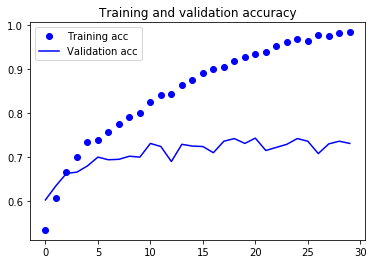

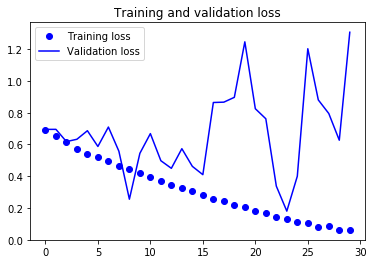

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 대략적으로 70 ~ 72% 검증 정확도를 보여줌
- 검증 손실은 다섯번의 에포크만에 최솟값에 다다른 후 진전이 없음
- 과대적합으로 판단
- 드롭아웃이나 가중치 감소처럼 과대적합 방법 사용 가능
- 비전 쪽에 사용하는 방법은 데이터 증식 방법이 있음